> You can open this notebook in Colab by clicking the Colab icon. Colab provides GPU for free. You can also run this notebook locally by installing the dependencies listed in `requirements.txt`.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/osbm/unet_explainer/blob/main/tutorial.ipynb)

### Preamble

The second part of this hands-on will allow you to study in depth the structure and performance of the popular deep learning U-Net architecture, in the context of 2D multi-slice prostate MR images segmentation. You will use the (prostate-158 train dataset)[https://zenodo.org/record/6481141] (139 mri images) and (prostate-158 test dataset)[https://zenodo.org/record/6592345] dataset (19 mri images).

### Objectives

* Study how to code a deep learning segmentation method with the pytorch library.
* Compare the performance of a U-Net model based on the choice of key hyper-parameters.


## Reminder on the U-Net architecture

U-Net is based on a two-stage convolutional network architecture. The first part, known as the encoder, is similar to conventional CNNs and extracts high-level information. The second part is the decoder, which uses information from the encoder and applies a set of convolutions and upsampling operations to gradually transform feature maps with the purpose of reconstructing segmentation maps at the resolution of the imput image. U-Net architecture also integrates skip connections between the encoder and decoder parts with the goal of retrieving details that were potentially lost during the downsampling while also stabilizing the learning procedure. An illustration of the network architecture is given below.


![unet-architecture](./assets/unet-architecture.png)

The U-Net architecture can be defined through the following main parameters:
- the number of feature maps at the first level
- the number of levels
- the use of the batch normalizations at each level
- the type of activation functions
- the use of dropout operations
- the use of data augmentation

The performance of deep learning model also depends on the optimization conditions that were used during the learning process, the main ones being:
- the optimization algorithm (*ADAM* and *RMSprop* being among the most popular)
- the learning rate


## Install requirements:

I have made a python package that you can install with the below command. This package will also automatically install all the libraries needed for this tutorial. If you wanto see how the functions and the classes are implemented, you can check the source code in [unet_explainer](https://github.com/osbm/unet_explainer/) repository.

In [ ]:
!pip install git+https://github.com/osbm/unet_explainer.git

In [1]:
# lets import our functions and classes
from unet_pytorch import (
    ProstateDataset,  # our dataset class
    print_model_info, # function to print pytorch model info
    fit_model,        # function to train and validate pytorch model
    predict,          # function to predict on pytorch model
    set_seed,         # helper function to set seed for reproducibility
    plot_overlay_4x4, # helper function to plot 4x4 grid of images
    plot_predictions, # helper function to plot predictions
    plot_one_example, # helper function to plot one example
    plot_history,     # helper function to plot training history
)

# third party libraries
import torch                                  # pytorch deep learning framework
from torch.utils.data import DataLoader       # dataloader class from pytorch to load data

import monai                                  # monai medical imaging framework (built on top of pytorch)
from monai.networks.nets import UNet          # unet model from monai (there are other models that you use with a single line)

import albumentations as A                    # albumentations library for image augmentation and preprocessing
from albumentations.pytorch import ToTensorV2 # albumentations class to convert images to tensors

# built-in libraries
import os

### Lets download the data
I have uploaded a preprocessed version of the data on a huggingface dataset. You can download it by running the following cell.

In [2]:
if not os.path.exists('data'):
    !wget -q https://huggingface.co/datasets/osbm/unet-explainer-data/resolve/main/data.zip
    !unzip -q data.zip

We should set RNG seed for reproducibility. This way we can get the same results on each run.

In [3]:
set_seed(42)

Seed set to 42.


# Instruction: play with these values to see how they affect the performance of the model

In [4]:
image_size = 128
train_transforms = A.Compose([
    A.Resize(height=image_size, width=image_size),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=5, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=0, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    ToTensorV2(),
])

valid_transforms = A.Compose([
    A.Resize(height=image_size, width=image_size),
    ToTensorV2(),
])
train_ds = ProstateDataset(folder='data/train', transform=train_transforms)
valid_ds = ProstateDataset(folder='data/valid', transform=valid_transforms)
test_ds = ProstateDataset(folder='data/test', transform=valid_transforms)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=16, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=16, shuffle=False)


## Lets see augmented training data and compare it with the un-augmented validation data

torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])


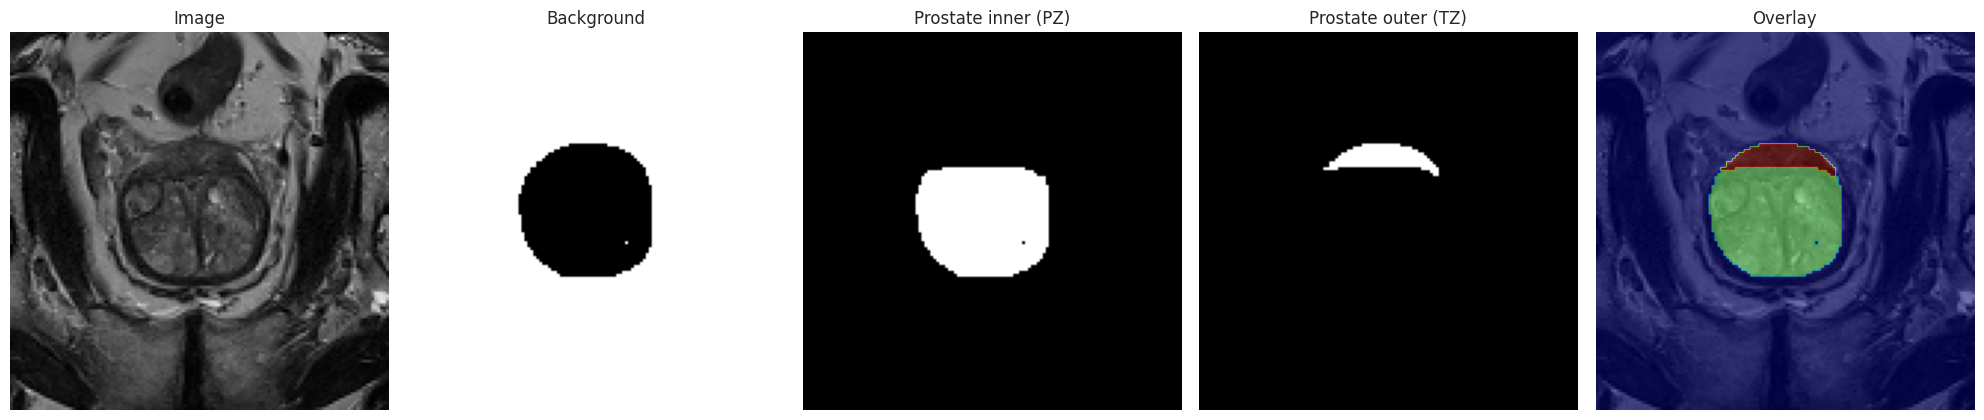

Overlay examples:


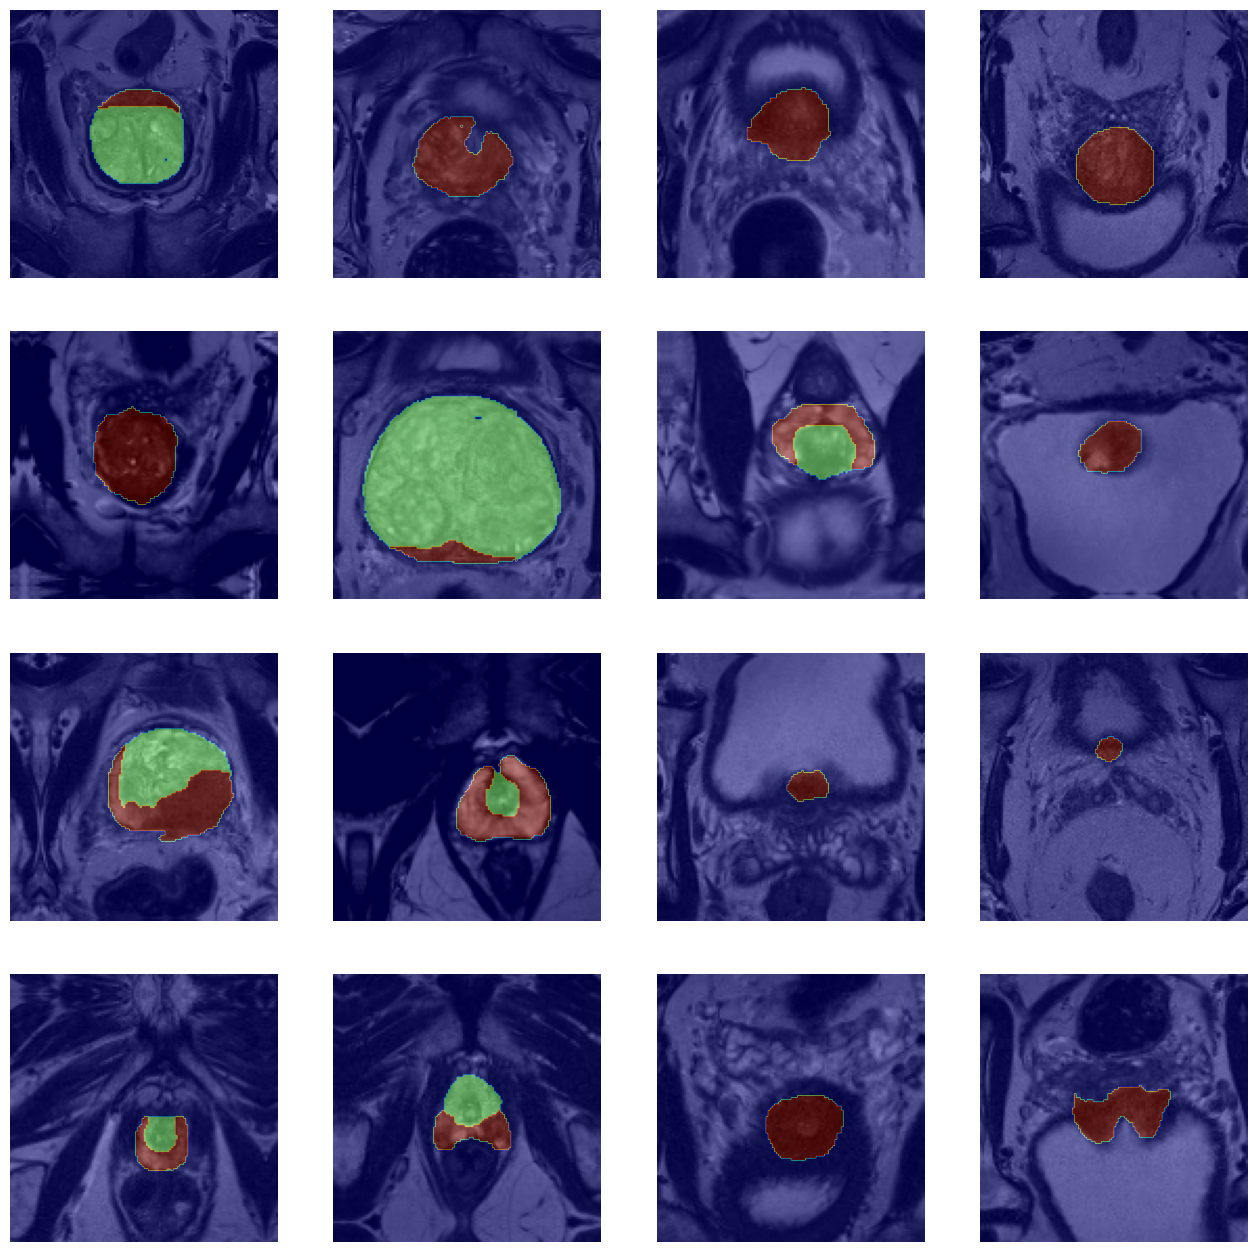

In [5]:
for x, y in train_loader:
    print(x.shape) # shape = [batch_size, channels, height, width]
    print(y.shape) # shape = [batch_size, channels, height, width]
    plot_one_example(x[0], y[0])
    print("Overlay examples:")
    plot_overlay_4x4((x, y))
    break

In [6]:
model = UNet( # these are the hyperparameters we can change
    spatial_dims=2, # 2d image
    in_channels=1,  # we only used  T2 weighed MRI images
    out_channels=3, # 3 labels
    channels=[16, 32, 64, 128, 256, 512],
    strides=(2, 2, 2, 2, 2), # CNN strides
    num_res_units=4, # residual connections
    dropout=0.15, # dropout rate
)
print_model_info(model)

Total number of trainable parameters: 12,809,864 (48.87MB)


In [ ]:
# we will use the Adam optimizer with a learning rate of 0.0001
optimizer = torch.optim.Adam(model.parameters(), 1e-4)

In [ ]:
# we will use the Dice loss function from monai. You can also use other compount loss functions from monai
loss = monai.losses.DiceLoss(include_background=True, to_onehot_y=True, softmax=True)

In [ ]:
# move model weights to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


# start training
model, history = fit_model(
    model=model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    optimizer=optimizer,
    loss=loss,
    device=device,
    epochs=30,
)


In [ ]:
plot_history(history)

In [ ]:
# load the best model
model.load_state_dict(torch.load('best_model.pth'))

In [ ]:
# lets see how our model performs on the test set
x, y, y_hat = predict(model, test_loader=test_loader, device=device, final_activation="softmax")

In [ ]:
# here is the entire test set with predictions
print(x.shape, y.shape, y_hat.shape)

In [ ]:
plot_predictions(x, y, y_hat, num_examples_to_plot=10)